In [1]:
# coding: utf-8
__author__ = "Nicholas Metherall"
__copyright__ = "Copyright 2025, The Pacific Community (SPC)"
__license__ = "CreativeCommons"
__version__ = "0.1"
__email__ = "nicholasm@spc.int"
__status__ = "Development"

import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
import numpy as np
from fiona.crs import from_epsg
import shapely
import warnings
from shapely.ops import unary_union
from shapely.geometry import box
warnings.filterwarnings('ignore')
# coastal ndti

<Axes: >

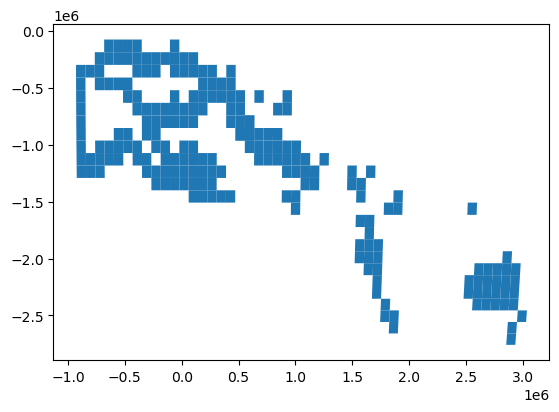

In [2]:
coastal_grids = gpd.read_file("coastal_macblue_grids.geojson")
coastal_grids.plot()

In [3]:
coastal_grids

,level_1,GID_0,COUNTRY,index,uuid,index_right,geometry
0,16,FJI,Fiji,1,FJI1,0,"POLYGON ((2853497.38 -2758834.497, 2860754.992..."
1,17,VUT,Vanuatu,2,VUT2,0,"POLYGON ((1820480.449 -2658691.923, 1824951.85..."
2,17,FJI,Fiji,3,FJI3,0,"POLYGON ((2860754.992 -2658691.923, 2867781.49..."
3,18,VUT,Vanuatu,4,VUT4,0,"POLYGON ((1744734.194 -2557719.247, 1748864.58..."
4,18,VUT,Vanuatu,5,VUT5,0,"POLYGON ((1824951.858 -2557719.247, 1829272.15..."
...,...,...,...,...,...,...,...
201,40,PNG,Papua New Guinea,225,PNG225,0,"POLYGON ((-681479.65 -185890.359, -681566.064 ..."
202,40,PNG,Papua New Guinea,226,PNG226,0,"POLYGON ((-598876.056 -185890.359, -598951.995..."
203,40,PNG,Papua New Guinea,227,PNG227,0,"POLYGON ((-516272.462 -185890.359, -516337.927..."
204,40,PNG,Papua New Guinea,228,PNG228,0,"POLYGON ((-433668.868 -185890.359, -433723.859..."


In [7]:
def quarter(grid): 
    minx, miny, maxx, maxy = grid.bounds
    midx = (minx + maxx) / 2
    midy = (miny + maxy) / 2
    # Return tuples of (geometry, quarter_name)
    return [
        (box(minx, midy, midx, maxy), 'Q1'),
        (box(midx, midy, maxx, maxy), 'Q2'),
        (box(minx, miny, midx, midy), 'Q3'),
        (box(midx, miny, maxx, midy), 'Q4'),
    ]

# Build a list of dicts for each sub-square
records = []
for idx, row in coastal_grids.iterrows():
    for geom, quarter_name in quarter(row.geometry):
        rec = row.to_dict()
        rec['geometry'] = geom
        rec['quarter'] = quarter_name
        records.append(rec)

quarters_gdf = gpd.GeoDataFrame(records, crs=coastal_grids.crs)

In [14]:
quarters_gdf['quid'] = quarters_gdf['uuid']+quarters_gdf['quarter']+'_'+quarters_gdf['level_1'].astype(str)

In [15]:
quarters_gdf

,level_1,GID_0,COUNTRY,index,uuid,index_right,geometry,quarter,quid
0,16,FJI,Fiji,1,FJI1,0,"POLYGON ((2897136.745 -2708763.21, 2897136.745...",Q1,FJI1Q1_16
1,16,FJI,Fiji,1,FJI1,0,"POLYGON ((2940776.111 -2708763.21, 2940776.111...",Q2,FJI1Q2_16
2,16,FJI,Fiji,1,FJI1,0,"POLYGON ((2897136.745 -2758834.497, 2897136.74...",Q3,FJI1Q3_16
3,16,FJI,Fiji,1,FJI1,0,"POLYGON ((2940776.111 -2758834.497, 2940776.11...",Q4,FJI1Q4_16
4,17,VUT,Vanuatu,2,VUT2,0,"POLYGON ((1862824.986 -2608205.585, 1862824.98...",Q1,VUT2Q1_17
...,...,...,...,...,...,...,...,...,...
819,40,PNG,Papua New Guinea,228,PNG228,0,"POLYGON ((-351065.274 -185890.359, -351065.274...",Q4,PNG228Q4_40
820,40,PNG,Papua New Guinea,229,PNG229,0,"POLYGON ((-61959.242 -130128.274, -61959.242 -...",Q1,PNG229Q1_40
821,40,PNG,Papua New Guinea,229,PNG229,0,"POLYGON ((-20650.898 -130128.274, -20650.898 -...",Q2,PNG229Q2_40
822,40,PNG,Papua New Guinea,229,PNG229,0,"POLYGON ((-61959.242 -185890.359, -61959.242 -...",Q3,PNG229Q3_40


In [ ]:
# Collect all new rows as dicts
records = []
for idx, row in quarters_gdf.iterrows():
    for geom, quarter_name in quarter(row.geometry):
        rec = row.to_dict()
        rec['geometry'] = geom
        rec['quarter'] = quarter_name  # Optional: label the quarter
        records.append(rec)

quarters_gdf = gpd.GeoDataFrame(records, crs=coastal_grids.crs)

<Axes: >

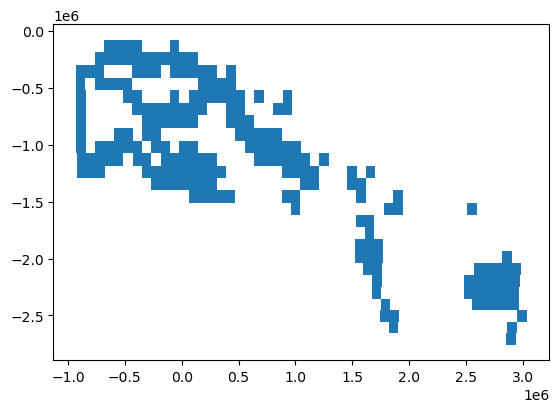

In [16]:
quarters_gdf.plot()

In [18]:
# Remove index_right if it exists
if 'index_right' in quarters_gdf.columns:
    quarters_gdf = quarters_gdf.drop(columns='index_right')

if 'index_right' in coastline_lines.columns:
    coastline_lines = coastline_lines.drop(columns='index_right')

In [19]:
# Only keep grids that intersect with any coastline
coastline_lines = gpd.read_file("coastline_lines.geojson")

subset = gpd.sjoin(quarters_gdf, coastline_lines, how="inner", predicate="intersects")


<Axes: >

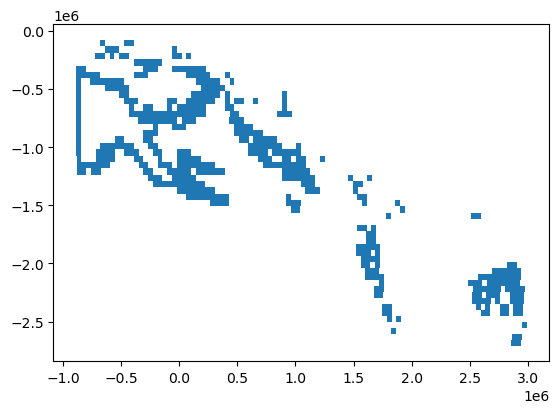

In [21]:
subset.plot()

In [22]:
quarter_grids = subset
quarter_grids.to_file("quarter_grids.geojson")
